# HW2: Windy Gridworld with King's Moves

## 环境设置
- 网格：7行 × 10列
- 坐标系统：左上角为原点(0,0)，行号0-6，列号0-9
- 动作：8向移动（King's moves）
- 目标状态：(3,7) - episode结束
- 死亡状态：(0,9) - 奖励-100，episode结束
- 每步奖励：-1
- 风向：特定列有向上的风

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
import time

# 配置中文字体支持
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

## 1. 环境定义

In [2]:
class WindyGridworld:
    def __init__(self, king_moves=True, absorbing_state=None):
        """
        初始化Windy Gridworld环境
        
        参数:
            king_moves: bool - 是否允许8向移动，False则只允许4向(Rook moves)
            absorbing_state: tuple - 吸收状态位置，如(0,3)，奖励+5
        """
        self.rows = 7
        self.cols = 10
        self.goal_state = (3, 7)  # 目标状态（左上角为(0,0)）
        self.death_state = (0, 9)  # 死亡状态
        self.absorbing_state = absorbing_state  # 吸收状态（任务7）
        
        # 风向定义：列索引 -> 向上推的格数（0-based索引）
        self.wind = {
            3: 1, 4: 1, 5: 1,  # 列3,4,5: 向上1格
            6: 2, 7: 2,        # 列6,7: 向上2格  
            8: 1               # 列8: 向上1格
        }
        
        # 动作定义
        if king_moves:
            # 8向移动（King's moves）
            self.actions = ['n', 'ne', 'e', 'se', 's', 'sw', 'w', 'nw']
            self.action_effects = {
                'n': (-1, 0), 'ne': (-1, 1), 'e': (0, 1), 'se': (1, 1),
                's': (1, 0), 'sw': (1, -1), 'w': (0, -1), 'nw': (-1, -1)
            }
        else:
            # 4向移动（Rook moves）
            self.actions = ['n', 'e', 's', 'w']
            self.action_effects = {
                'n': (-1, 0), 'e': (0, 1), 's': (1, 0), 'w': (0, -1)
            }
        
        # 所有状态（0-based索引）
        self.states = [(r, c) for r in range(self.rows) 
                       for c in range(self.cols)]
    
    def step(self, state, action):
        """
        执行动作，返回下一个状态和奖励
        
        返回: (next_state, reward, done)
        """
        # 如果已经在终止状态，不能再移动
        if self.is_terminal(state):
            return state, 0, True
        
        row, col = state
        d_row, d_col = self.action_effects[action]
        
        # 应用动作
        new_row = row + d_row
        new_col = col + d_col
        
        # 应用风（只影响垂直方向）
        if new_col in self.wind:
            new_row -= self.wind[new_col]  # 风向上推
        
        # 边界检查（0-based索引）
        new_row = max(0, min(self.rows - 1, new_row))
        new_col = max(0, min(self.cols - 1, new_col))
        
        next_state = (new_row, new_col)
        
        # ✅ 奖励设置（已修复）
        # 普通步骤：-1（鼓励最短路径）
        # 终止状态的即时奖励：
        if next_state == self.death_state:
            return next_state, -100, True  # 死亡：累积约-114
        elif next_state == self.absorbing_state:
            return next_state, 5, True     # 吸收：累积约-2
        elif next_state == self.goal_state:
            return next_state, 10, True    # ✅ 目标：累积约+1（最优！）
        else:
            return next_state, -1, False   # 普通步骤：-1
    
    def is_terminal(self, state):
        """判断是否为终止状态"""
        terminals = [self.goal_state, self.death_state]
        if self.absorbing_state:
            terminals.append(self.absorbing_state)
        return state in terminals
    
    def random_action(self):
        """随机选择一个动作"""
        return np.random.choice(self.actions)

## 2. SARSA 算法实现

In [3]:
def sarsa(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    SARSA算法 (on-policy)
    
    参数:
        env: WindyGridworld环境
        start_state: 起始状态
        episodes: 训练回合数
        alpha: 学习率
        gamma: 折扣因子
        epsilon: epsilon-greedy策略的探索率
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表
    Q = {(s, a): 0.0 for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    for episode in range(episodes):
        state = start_state
        
        # epsilon-greedy选择动作
        if np.random.random() < epsilon:
            action = env.random_action()
        else:
            action = max(env.actions, key=lambda a: Q[(state, a)])
        
        steps = 0
        
        while not env.is_terminal(state):
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # 选择下一个动作 (on-policy)
            if not done:
                if np.random.random() < epsilon:
                    next_action = env.random_action()
                else:
                    next_action = max(env.actions, key=lambda a: Q[(next_state, a)])
            else:
                next_action = None
            
            # SARSA更新
            if next_action is not None:
                Q[(state, action)] += alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            action = next_action
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

## 3. Q-Learning 算法实现

In [4]:
def q_learning(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    Q-Learning算法 (off-policy)
    
    参数同SARSA
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表
    Q = {(s, a): 0.0 for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    for episode in range(episodes):
        state = start_state
        steps = 0
        
        while not env.is_terminal(state):
            # epsilon-greedy选择动作
            if np.random.random() < epsilon:
                action = env.random_action()
            else:
                action = max(env.actions, key=lambda a: Q[(state, a)])
            
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # Q-Learning更新 (使用max)
            if not done:
                max_next_q = max(Q[(next_state, a)] for a in env.actions)
                Q[(state, action)] += alpha * (reward + gamma * max_next_q - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

## 4. 辅助函数

In [ ]:
def get_optimal_policy(Q, env):
    """从Q表提取最优策略"""
    policy = {}
    for state in env.states:
        if not env.is_terminal(state):
            policy[state] = max(env.actions, key=lambda a: Q[(state, a)])
    return policy

def get_optimal_path(policy, env, start_state, max_steps=100):
    """根据策略生成从起点到终点的路径"""
    path = [start_state]
    state = start_state
    steps = 0
    
    while not env.is_terminal(state) and steps < max_steps:
        if state in policy:
            action = policy[state]
            next_state, _, _ = env.step(state, action)
            path.append(next_state)
            state = next_state
            steps += 1
        else:
            break
    
    return path

def plot_learning_curve(steps_list, title, labels):
    """绘制学习曲线"""
    plt.figure(figsize=(12, 6))
    
    for steps, label in zip(steps_list, labels):
        # 计算移动平均
        window = 100
        if len(steps) >= window:
            smoothed = np.convolve(steps, np.ones(window)/window, mode='valid')
            plt.plot(smoothed, label=label, alpha=0.8)
    
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode (smoothed)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_gridworld(env, path=None, policy=None, show_all_policy=False):
    """
    Visualize gridworld with origin at top-left (0,0)
    
    参数:
        show_all_policy: 如果为True，显示所有格子的策略箭头；如果为False，只显示路径上的箭头
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw grid with wind zones
    for r in range(env.rows):
        for c in range(env.cols):
            # Determine base color based on wind strength
            if c in env.wind:
                wind_strength = env.wind[c]
                if wind_strength == 1:
                    base_color = 'lightyellow'  # Weak wind
                else:  # wind_strength == 2
                    base_color = 'wheat'  # Strong wind
            else:
                base_color = 'white'  # No wind
            
            # Override color for special states
            if (r, c) == env.goal_state:
                facecolor = 'lightgreen'
            elif (r, c) == env.death_state:
                facecolor = 'black'
            elif (r, c) == env.absorbing_state:
                facecolor = 'lightblue'
            else:
                facecolor = base_color
            
            ax.add_patch(Rectangle((c, r), 1, 1, 
                                  facecolor=facecolor, edgecolor='black', linewidth=0.5))
    
    # Draw wind strength numbers at the top of each column
    for col in range(env.cols):
        wind_strength = env.wind.get(col, 0)
        if wind_strength > 0:
            ax.text(col + 0.5, -0.3, str(wind_strength), 
                   ha='center', va='center', fontsize=14, fontweight='bold',
                   color='darkred')
    
    # Draw path
    if path:
        path_x = [c + 0.5 for r, c in path]
        path_y = [r + 0.5 for r, c in path]
        ax.plot(path_x, path_y, 'r-', linewidth=2, marker='o', 
               markersize=6, label='Optimal Path')
        # Mark start
        ax.plot(path_x[0], path_y[0], 'go', markersize=12, label='Start')
    
    # Draw policy arrows
    if policy:
        arrow_map = {
            'n': (0, -0.3), 'ne': (0.2, -0.2), 'e': (0.3, 0),
            'se': (0.2, 0.2), 's': (0, 0.3), 'sw': (-0.2, 0.2),
            'w': (-0.3, 0), 'nw': (-0.2, -0.2)
        }
        
        # 确定要显示箭头的状态集合
        if show_all_policy:
            # 显示所有状态的策略
            states_to_show = policy.keys()
        else:
            # 只显示路径上的状态（去除终止状态）
            if path:
                states_to_show = [s for s in path if not env.is_terminal(s)]
            else:
                states_to_show = []
        
        for state in states_to_show:
            if state in policy and state not in [env.goal_state, env.death_state, env.absorbing_state]:
                r, c = state
                action = policy[state]
                dx, dy = arrow_map[action]
                x = c + 0.5
                y = r + 0.5
                ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.05,
                        fc='blue', ec='blue', alpha=0.5, linewidth=1.5)
    
    # Set limits and invert Y axis to make (0,0) at top-left
    ax.set_xlim(0, env.cols)
    ax.set_ylim(-0.5, env.rows)
    ax.invert_yaxis()  # ⭐ KEY: Invert Y axis so row 0 is at top
    ax.set_aspect('equal')
    
    # Remove tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    title = 'Windy Gridworld (Origin at top-left)'
    if policy and not show_all_policy:
        title += ' - Path Only'
    ax.set_title(title, fontsize=14)
    
    # Add legend with wind info
    from matplotlib.patches import Patch
    legend_elements = []
    if path:
        legend_elements.append(plt.Line2D([0], [0], color='r', marker='o', label='Optimal Path'))
    legend_elements.extend([
        Patch(facecolor='lightyellow', edgecolor='black', label='Weak Wind (1)'),
        Patch(facecolor='wheat', edgecolor='black', label='Strong Wind (2)'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Goal'),
        Patch(facecolor='black', edgecolor='black', label='Death'),
    ])
    if env.absorbing_state:
        legend_elements.append(Patch(facecolor='lightblue', edgecolor='black', label='Absorbing'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

## 任务1: 使用SARSA和Q-learning从三个起点找最优策略（8向移动）

任务1: 8向移动 (King's Moves)

起始位置: (6, 0)

运行 SARSA...
SARSA 最优路径长度: 8 步
SARSA 路径: [(6, 0), (6, 1), (6, 2), (5, 3), (5, 4), (5, 5), (4, 6), (3, 7)]

运行 Q-Learning...
Q-Learning 最优路径长度: 15 步
Q-Learning 路径: [(6, 0), (6, 1), (6, 2), (6, 3), (4, 4), (3, 5), (2, 6), (0, 7), (0, 8), (1, 9)]...

生成可视化...


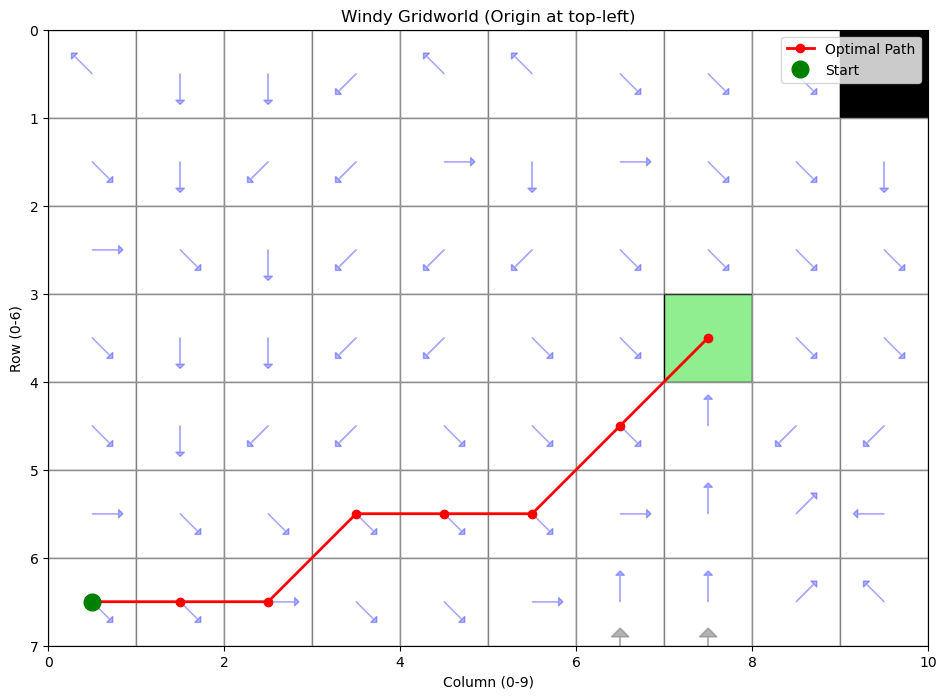

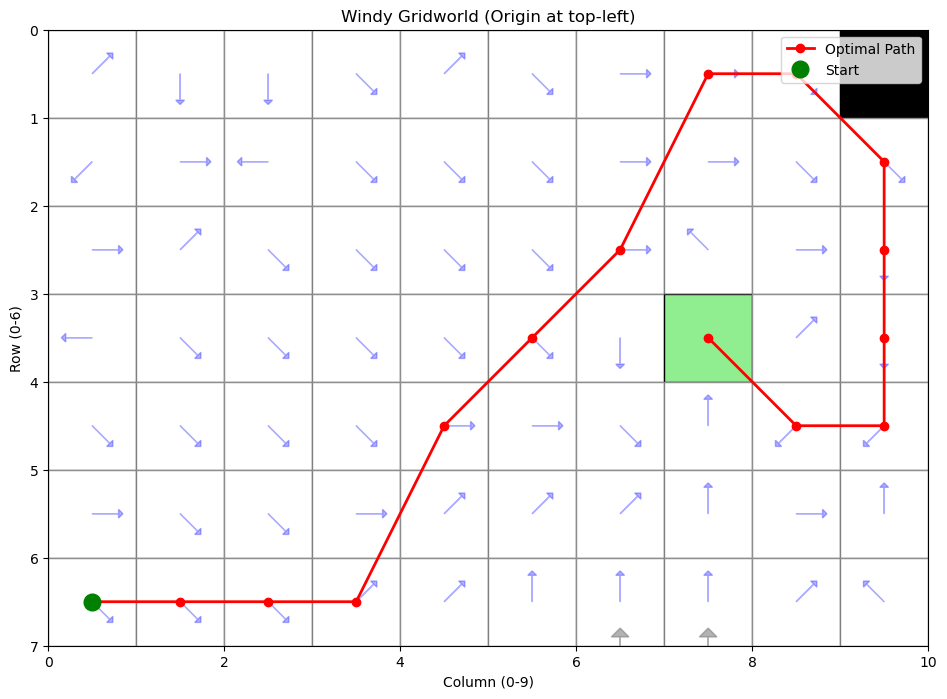


起始位置: (3, 0)

运行 SARSA...
SARSA 最优路径长度: 8 步
SARSA 路径: [(3, 0), (4, 1), (5, 2), (5, 3), (5, 4), (5, 5), (4, 6), (3, 7)]

运行 Q-Learning...
Q-Learning 最优路径长度: 15 步
Q-Learning 路径: [(3, 0), (4, 1), (5, 2), (5, 3), (5, 4), (4, 5), (1, 6), (0, 7), (0, 8), (1, 9)]...

生成可视化...


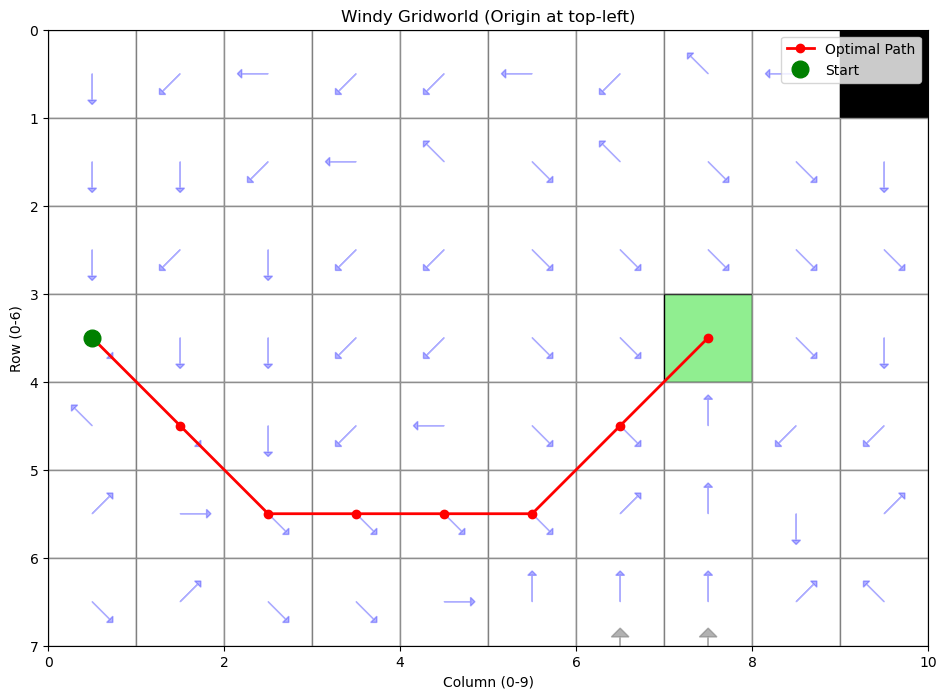

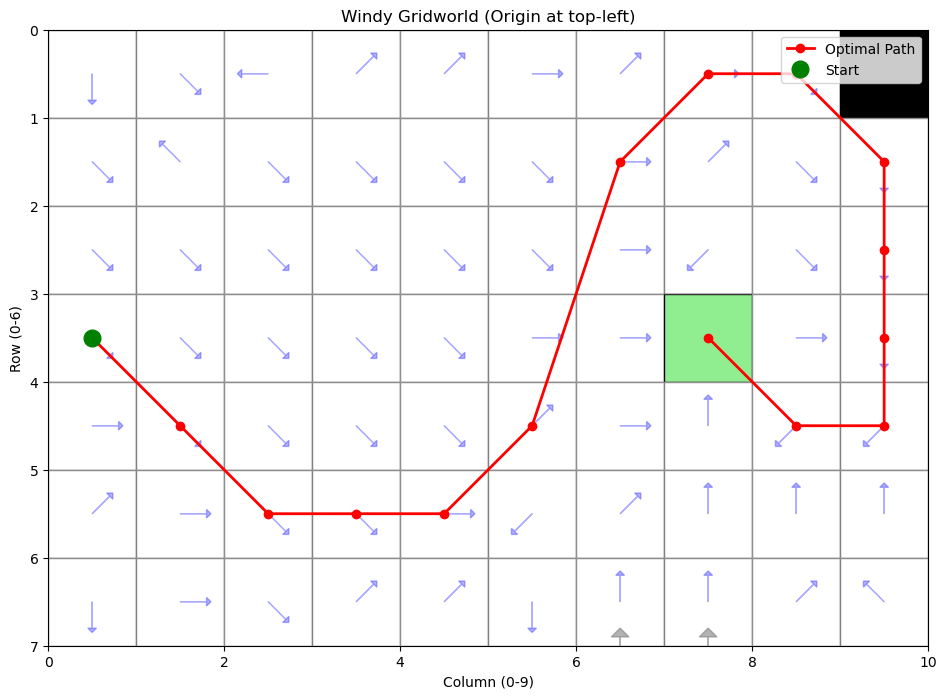


起始位置: (0, 6)

运行 SARSA...
SARSA 最优路径长度: 14 步
SARSA 路径: [(0, 6), (0, 5), (0, 4), (0, 3), (1, 2), (2, 1), (3, 2), (4, 1), (5, 2), (5, 3)]...

运行 Q-Learning...
Q-Learning 最优路径长度: 9 步
Q-Learning 路径: [(0, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]

生成可视化...


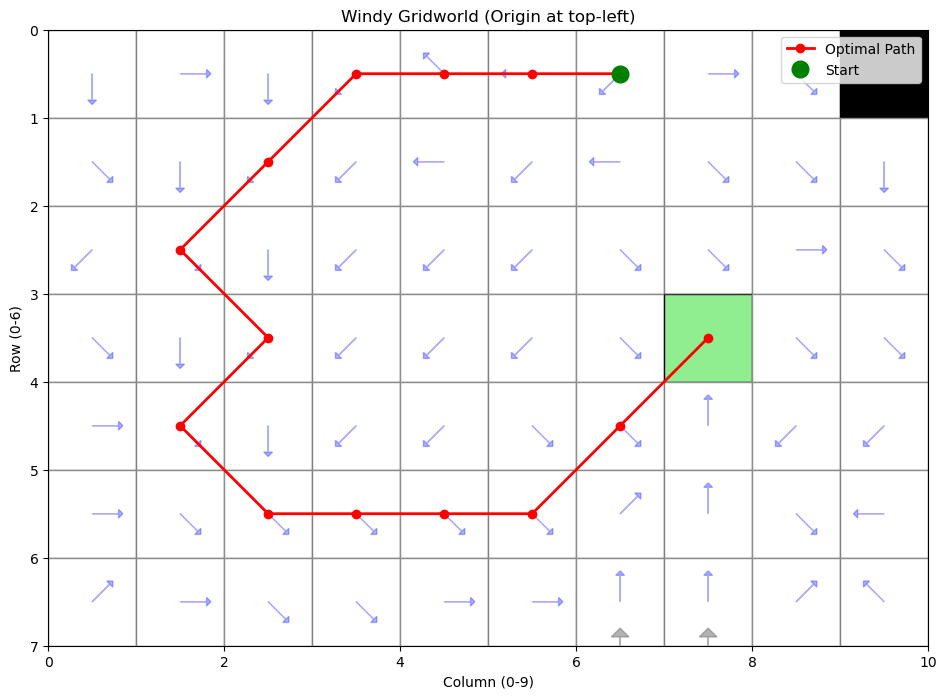

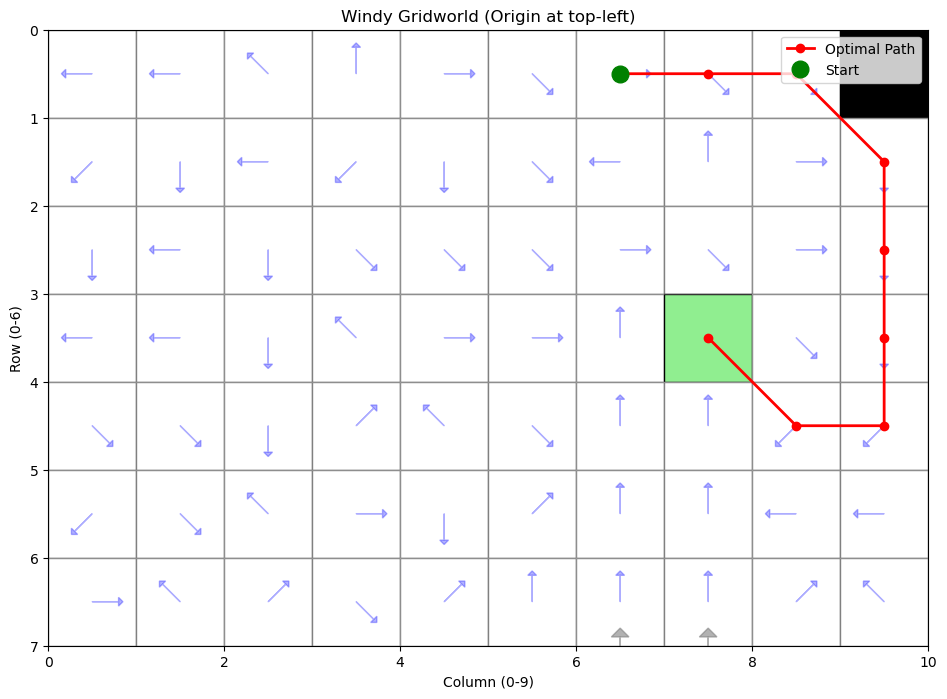

In [6]:
# 创建环境（8向移动）
env_king = WindyGridworld(king_moves=True)

# 三个起始位置（左上角为(0,0)）
start_states = [(6, 0), (3, 0), (0, 6)]

print("=" * 60)
print("任务1: 8向移动 (King's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA...")
    Q_sarsa, steps_sarsa = sarsa(env_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa = get_optimal_policy(Q_sarsa, env_king)
    path_sarsa = get_optimal_path(policy_sarsa, env_king, start)
    print(f"SARSA 最优路径长度: {len(path_sarsa)} 步")
    print(f"SARSA 路径: {path_sarsa[:10]}..." if len(path_sarsa) > 10 else f"SARSA 路径: {path_sarsa}")
    
    # Q-Learning
    print("\n运行 Q-Learning...")
    Q_qlearn, steps_qlearn = q_learning(env_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_qlearn = get_optimal_policy(Q_qlearn, env_king)
    path_qlearn = get_optimal_path(policy_qlearn, env_king, start)
    print(f"Q-Learning 最优路径长度: {len(path_qlearn)} 步")
    print(f"Q-Learning 路径: {path_qlearn[:10]}..." if len(path_qlearn) > 10 else f"Q-Learning 路径: {path_qlearn}")
    
    # 可视化
    print("\n生成可视化...")
    visualize_gridworld(env_king, path=path_sarsa, policy=policy_sarsa)
    visualize_gridworld(env_king, path=path_qlearn, policy=policy_qlearn)

## 任务2: 仅允许Rook移动（4向移动）的对比

任务2: 4向移动 (Rook's Moves)

起始位置: (6, 0)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 10 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 10 步


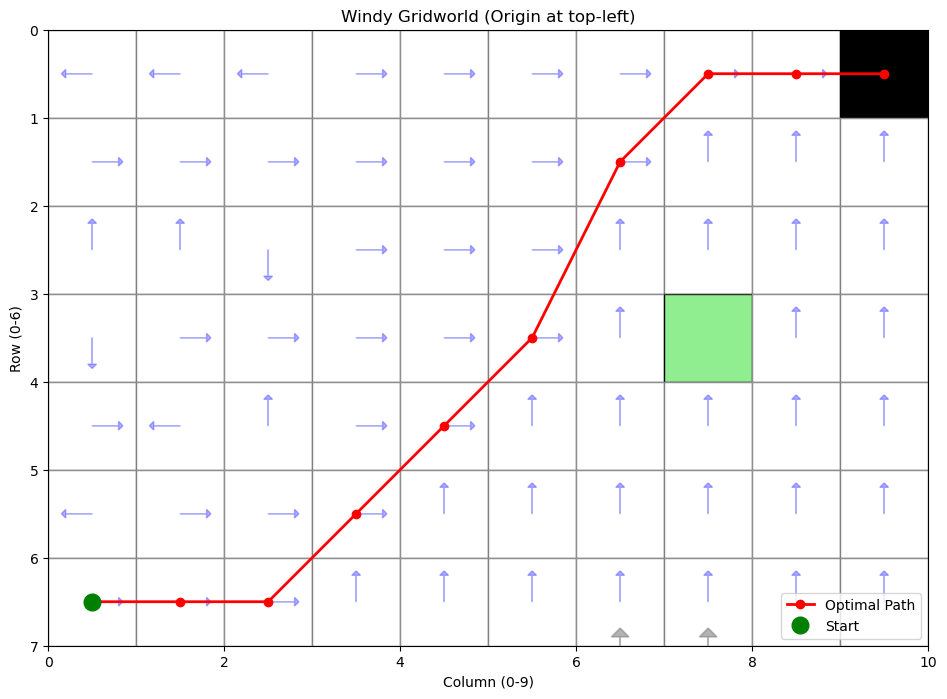


起始位置: (3, 0)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 10 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 10 步


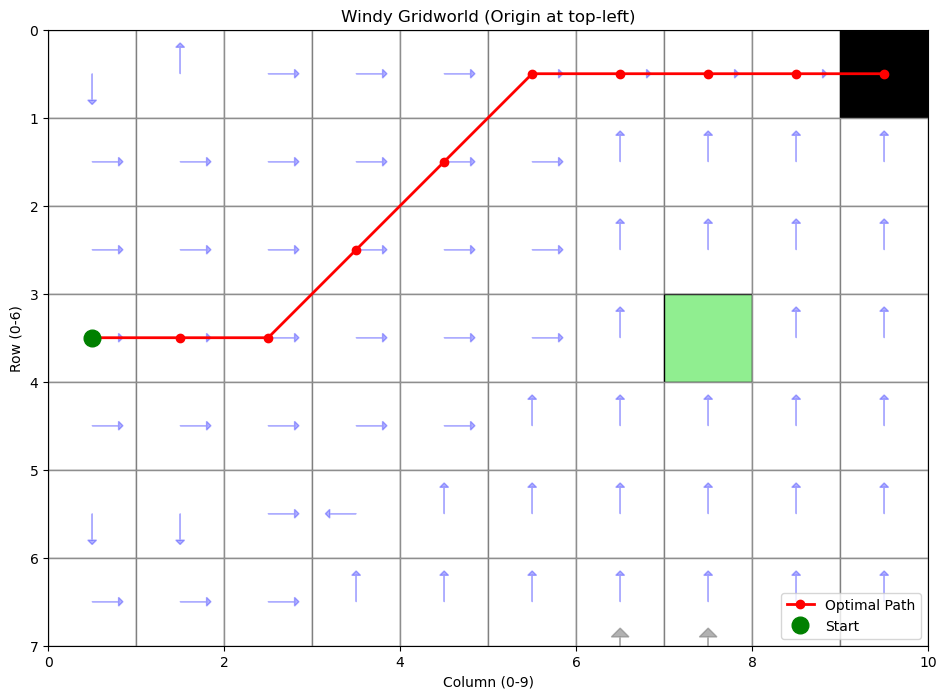


起始位置: (0, 6)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 4 步

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 4 步


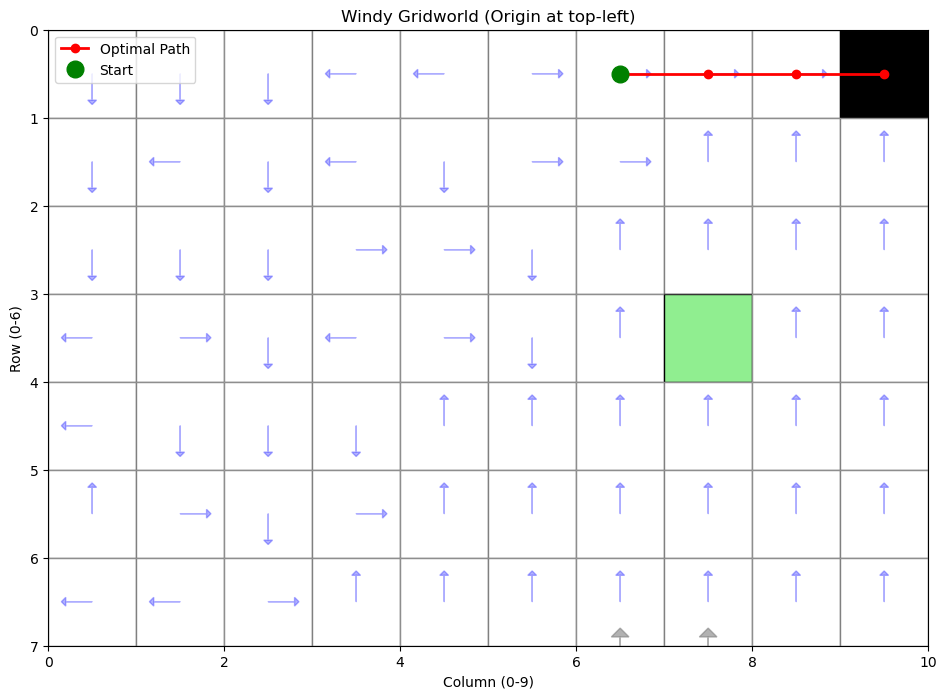

In [7]:
# 创建环境（4向移动）
env_rook = WindyGridworld(king_moves=False)

print("=" * 60)
print("任务2: 4向移动 (Rook's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA (4向)...")
    Q_sarsa_rook, steps_sarsa_rook = sarsa(env_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_rook = get_optimal_policy(Q_sarsa_rook, env_rook)
    path_sarsa_rook = get_optimal_path(policy_sarsa_rook, env_rook, start)
    print(f"SARSA (4向) 最优路径长度: {len(path_sarsa_rook)} 步")
    
    # Q-Learning
    print("\n运行 Q-Learning (4向)...")
    Q_qlearn_rook, steps_qlearn_rook = q_learning(env_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_qlearn_rook = get_optimal_policy(Q_qlearn_rook, env_rook)
    path_qlearn_rook = get_optimal_path(policy_qlearn_rook, env_rook, start)
    print(f"Q-Learning (4向) 最优路径长度: {len(path_qlearn_rook)} 步")
    
    # 可视化
    visualize_gridworld(env_rook, path=path_sarsa_rook, policy=policy_sarsa_rook)

## 任务7: 添加吸收状态(0,3)，奖励+5

任务7: 添加吸收状态(0,3)，奖励+5

8向移动 + 吸收状态

起始位置: (6, 0)
SARSA 路径长度: 5 步
路径: [(6, 0), (5, 1), (4, 2), (2, 3), (0, 3)]


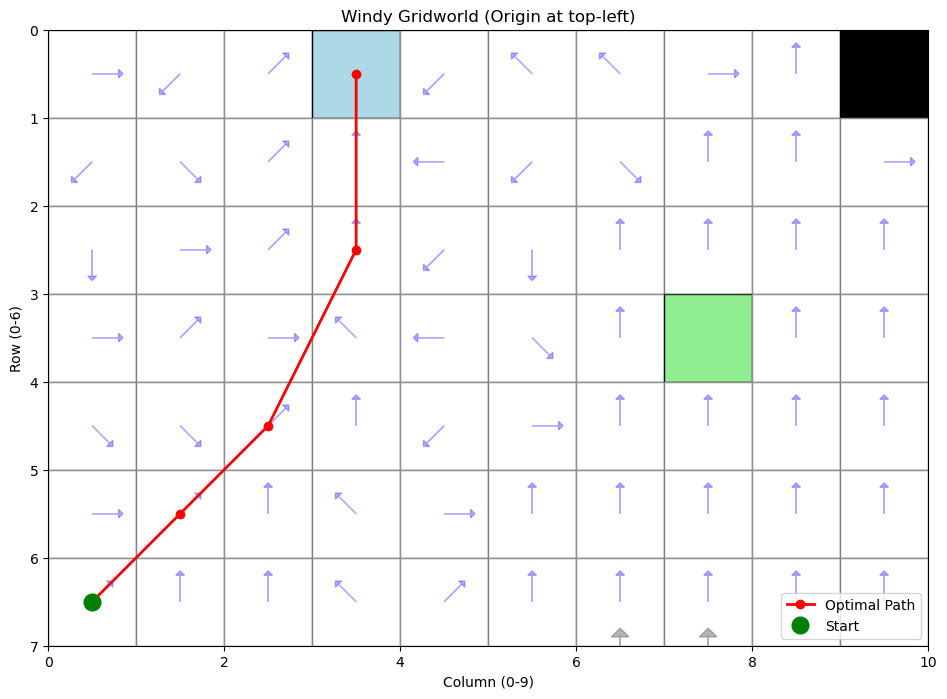


起始位置: (3, 0)
SARSA 路径长度: 4 步
路径: [(3, 0), (3, 1), (2, 2), (0, 3)]


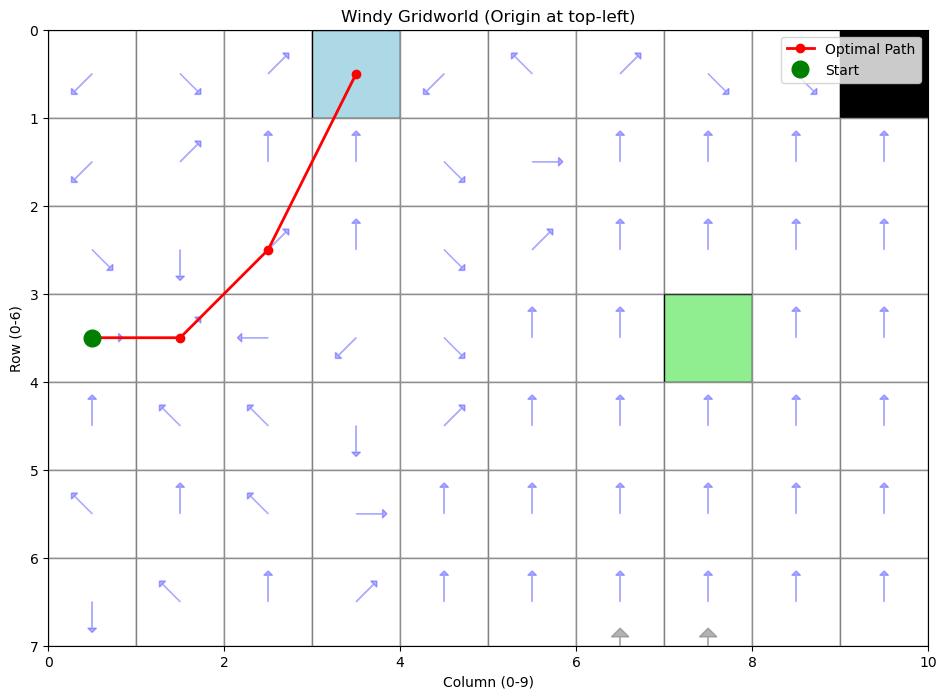


起始位置: (0, 6)
SARSA 路径长度: 4 步
路径: [(0, 6), (0, 5), (0, 4), (0, 3)]


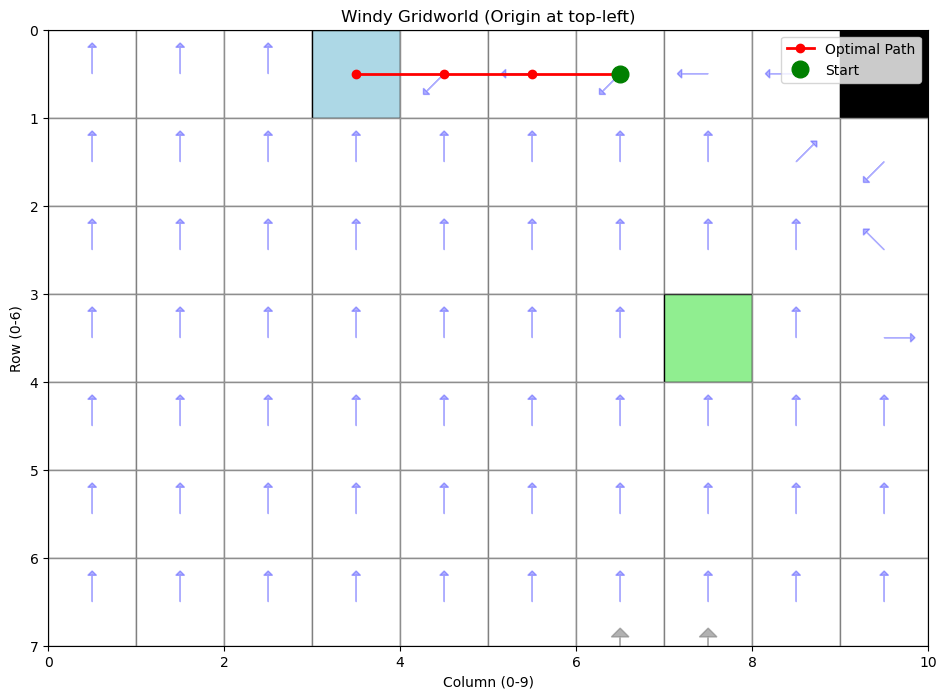


4向移动 + 吸收状态

起始位置: (6, 0)
SARSA 路径长度: 7 步
路径: [(6, 0), (6, 1), (5, 1), (5, 2), (4, 3), (2, 3), (0, 3)]


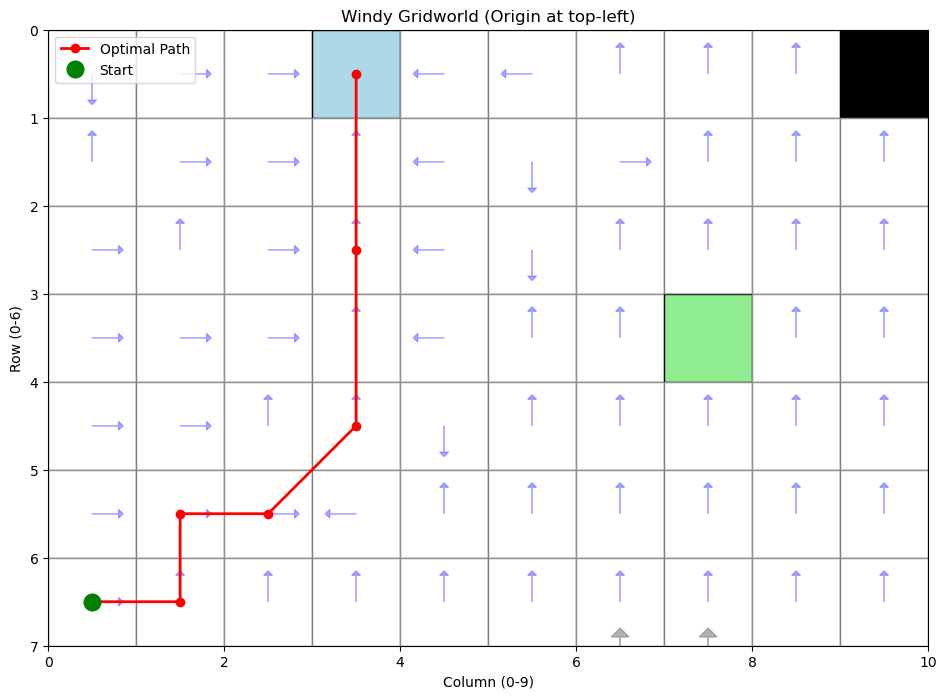


起始位置: (3, 0)
SARSA 路径长度: 5 步
路径: [(3, 0), (3, 1), (3, 2), (2, 3), (0, 3)]


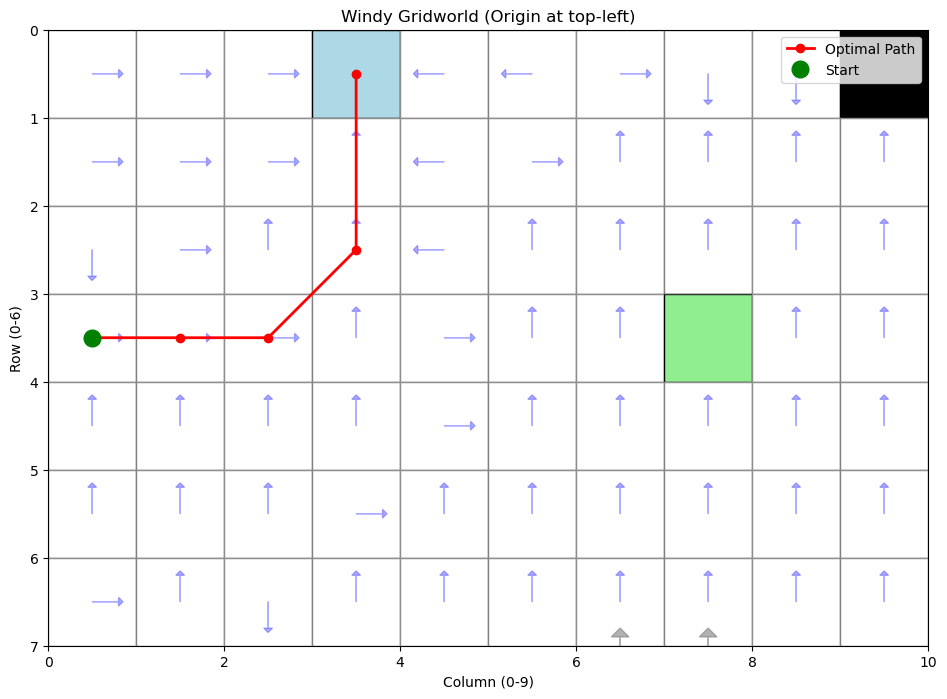


起始位置: (0, 6)
SARSA 路径长度: 4 步
路径: [(0, 6), (0, 5), (0, 4), (0, 3)]


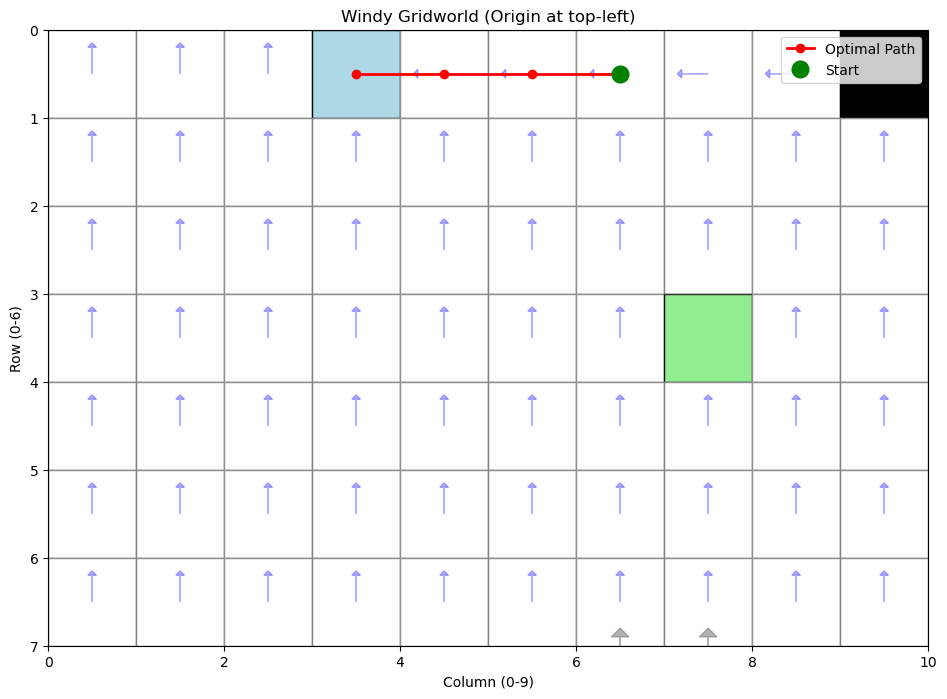

In [8]:
# 创建带吸收状态的环境（吸收状态坐标为(0,3)）
env_absorbing_king = WindyGridworld(king_moves=True, absorbing_state=(0, 3))
env_absorbing_rook = WindyGridworld(king_moves=False, absorbing_state=(0, 3))

print("=" * 60)
print("任务7: 添加吸收状态(0,3)，奖励+5")
print("=" * 60)

# 8向移动
print("\n" + "="*60)
print("8向移动 + 吸收状态")
print("="*60)

for start in start_states:
    print(f"\n起始位置: {start}")
    
    Q_sarsa_abs, _ = sarsa(env_absorbing_king, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs = get_optimal_policy(Q_sarsa_abs, env_absorbing_king)
    path_sarsa_abs = get_optimal_path(policy_sarsa_abs, env_absorbing_king, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs)} 步")
    print(f"路径: {path_sarsa_abs}")
    
    visualize_gridworld(env_absorbing_king, path=path_sarsa_abs, policy=policy_sarsa_abs)

# 4向移动  
print("\n" + "="*60)
print("4向移动 + 吸收状态")
print("="*60)

for start in start_states:
    print(f"\n起始位置: {start}")
    
    Q_sarsa_abs_rook, _ = sarsa(env_absorbing_rook, start, episodes=5000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs_rook = get_optimal_policy(Q_sarsa_abs_rook, env_absorbing_rook)
    path_sarsa_abs_rook = get_optimal_path(policy_sarsa_abs_rook, env_absorbing_rook, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs_rook)} 步")
    print(f"路径: {path_sarsa_abs_rook}")
    
    visualize_gridworld(env_absorbing_rook, path=path_sarsa_abs_rook, policy=policy_sarsa_abs_rook)

## 对比分析

In [9]:
# 这里可以添加更多的对比分析和可视化
print("\n" + "="*60)
print("总结")
print("="*60)
print("\n坐标系统说明：")
print("   - 左上角为原点(0,0)")
print("   - 行号：0-6（从上往下递增）")
print("   - 列号：0-9（从左往右递增）")
print("   - 目标状态：(3,7)")
print("   - 死亡状态：(0,9)")
print("   - 吸收状态：(0,3)")
print("\n起始位置：")
print("   - S1: (6,0) - 左下角")
print("   - S2: (3,0) - 左侧中间（与目标同行）")
print("   - S3: (0,6) - 上方强风区")
print("\n1. SARSA vs Q-Learning:")
print("   - SARSA是on-policy算法，学习当前策略的价值")
print("   - Q-Learning是off-policy算法，学习最优策略的价值")
print("   - 在确定性环境中，两者应该收敛到相同的最优策略")
print("\n2. 8向 vs 4向移动:")
print("   - 8向移动允许对角线移动，路径更短")
print("   - 4向移动路径更长，但实现更简单")
print("\n3. 吸收状态的影响:")
print("   - 吸收状态(0,3)提供+5奖励")
print("   - 可能改变某些起点的最优策略")
print("   - 需要权衡：绕路获得+5 vs 直接到目标")


总结

坐标系统说明：
   - 左上角为原点(0,0)
   - 行号：0-6（从上往下递增）
   - 列号：0-9（从左往右递增）
   - 目标状态：(3,7)
   - 死亡状态：(0,9)
   - 吸收状态：(0,3)

起始位置：
   - S1: (6,0) - 左下角
   - S2: (3,0) - 左侧中间（与目标同行）
   - S3: (0,6) - 上方强风区

1. SARSA vs Q-Learning:
   - SARSA是on-policy算法，学习当前策略的价值
   - Q-Learning是off-policy算法，学习最优策略的价值
   - 在确定性环境中，两者应该收敛到相同的最优策略

2. 8向 vs 4向移动:
   - 8向移动允许对角线移动，路径更短
   - 4向移动路径更长，但实现更简单

3. 吸收状态的影响:
   - 吸收状态(0,3)提供+5奖励
   - 可能改变某些起点的最优策略
   - 需要权衡：绕路获得+5 vs 直接到目标
